## Main plot for the seasonality analysis

In [1]:
import numpy as np
import pandas as pd
import os

from lib.plotting import *
from lib.preferences import *
from lib.response  import *

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import seaborn as sns

# inline stylization
%matplotlib inline
sns.set_style("ticks")
sns.set_style('white')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [3]:
# Font sizes
plt.rc('font', size=12)         # controls default text sizes
plt.rc('axes', titlesize=14)    # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

## Settings

In [4]:
savefig = True
output_dir = "../figs/review"

## Load all individual simulations

In [5]:
expt_path = "../results/2021-02-10_seasonality"
sim_complete = [s for s in os.listdir(expt_path) 
                if "run_diagnostics.json" in os.listdir(os.path.join(expt_path, s))]
n_sims = len(sim_complete)

ots = []
for sim in sim_complete:
    sim_path = os.path.join(expt_path, sim)
    
    # Load full data frame
    epoch_df = pd.read_csv(os.path.join(sim_path, "epoch_df.csv"))
    epoch_df.index = epoch_df.name
    og = pd.read_csv(os.path.join(sim_path, "og.csv"))
    op = pd.read_csv(os.path.join(sim_path, "op.csv"))

    # Merge on time
    ot = pd.merge(left=op, right=og, on="t0")
    
    ots.append(ot)

In [6]:
ot_all = pd.concat(ots)

## Load average data

In [7]:
bin_path = "../analysis/2021-02-10_seasonality"

In [8]:
# LOAD PREVALENCE AND DIVERSITY
print("Loading prevalence and diversity data.")
ops_mean = pd.read_csv(bin_path + "/ops_mean.csv")
ops_std = pd.read_csv(bin_path + "/ops_stds.csv")
ops_se = pd.read_csv(bin_path + "/ops_se.csv")
ogs_mean = pd.read_csv(bin_path + "/ogs_mean.csv")
ogs_std = pd.read_csv(bin_path + "/ogs_stds.csv")
ogs_se = pd.read_csv(bin_path + "/ogs_se.csv")
epoch_df = pd.read_csv(bin_path + "/epoch_df.csv")
epoch_df.index = epoch_df.name

Loading prevalence and diversity data.


In [9]:
ots_mu = pd.merge(ops_mean, ogs_mean, on="t0")
ots_se = pd.merge(ops_se, ogs_se, on="t0")

## Preferences

In [10]:
genetic_names.update({
    "mean_k": "C.O.I ($k$)",
    "pi": "Nucl. Diversity ($\pi$)",
    "avg_l_ibd": "Avg. IBD\nTrack Length (bp)"
})

In [11]:
analysis_metrics = ["HX", "VX", 
                    'frac_mixed_samples','mean_k',
                    'n_segregating','pi','theta',
                    'f_ibd', 'l_ibd','f_ibs', 'l_ibs']

In [12]:
time_limits = (epoch_df.loc["Wet2009", "t0"], epoch_df.loc["Wet2015", "t0"])

In [13]:
se_alpha=0.25

In [14]:
ix = 0
ot = ots[ix]

## Plot prevalence

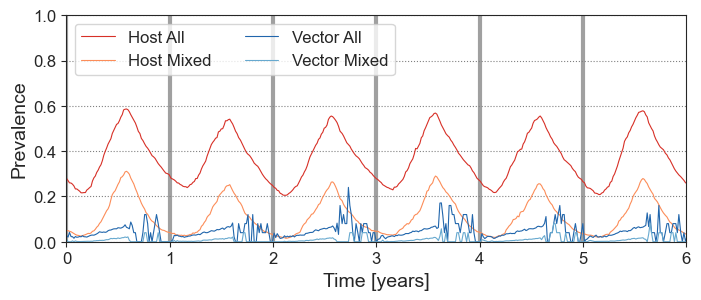

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

prevalence_trajectory_plot(ot, epoch_df, ax,
                           col_dt=prevalence_col_dt,
                           norm_t0=("Wet2009", "t0"),
                           indicate_epochs=[("Wet20%02d" % y, "t0") for y in np.arange(9, 15)],
                           indicate_equilibriums=None,
                           time_limits=time_limits,
                           years_per_major_tick=1)

ax.set_xlabel("Time [years]")
ax.set_ylabel("Prevalence")
ax.legend(loc="upper left", ncol=2)
ax.grid(axis='y', linestyle='dotted', color='grey', which='major')

if savefig:
    fig.savefig(os.path.join(output_dir, "sec4_main-prevalence.png"), bbox_inches="tight", pad_inches=0.5)
    fig.savefig(os.path.join(output_dir, "sec4_main-prevalence.pdf"), bbox_inches="tight", pad_inches=0.5)

## Plot genetics

In [16]:
metrics = ["mean_k", "pi", "f_ibd"]
n_metrics = len(metrics)

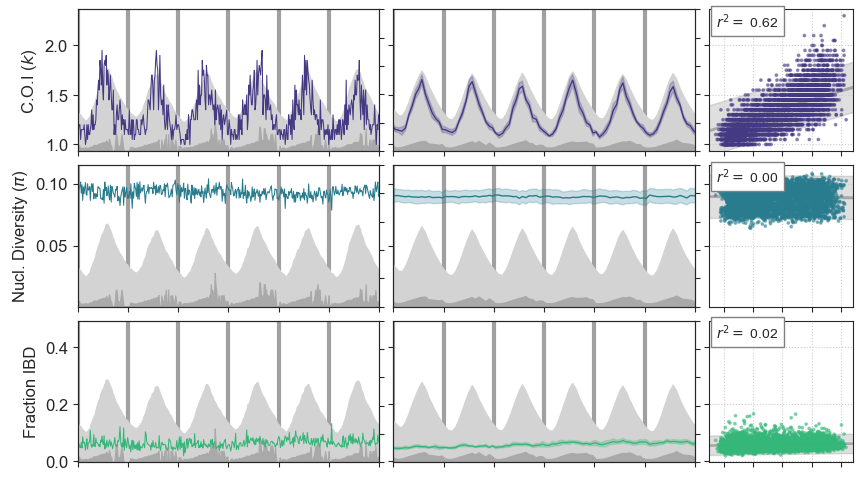

In [17]:
# Plot
fig = plt.figure(figsize=(10, n_metrics*2))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
gs = gridspec.GridSpec(n_metrics, 5)

# Prepare Plot Array
for j, metric in enumerate(metrics):
    ax0 = plt.subplot(gs[j, :2])
    ax1 = plt.subplot(gs[j, 2:4], sharey=ax0)
    ax2 = plt.subplot(gs[j, 4], sharey=ax1)

    # Raw
    genetic_trajectory_plot(metric, ot, epoch_df,
                            tight_metric_col_dt[metric], ax0,
                            norm_t0=("Wet2009", "t0"),
                            indicate_epochs=[("Wet20%02d" % y, "t0") for y in np.arange(9, 15)],
                            time_limits=time_limits,
                            years_per_major_tick=1)
    
    ax0.set_ylabel(genetic_names[metric], fontsize=12)
    
    
    # Averaged
    genetic_trajectory_average_plot(metric, ots_mu, ots_se, epoch_df,
                                    tight_metric_col_dt[metric], ax1,
                                    norm_t0=("Wet2009", "t0"),
                                    indicate_epochs=[("Wet20%02d" % y, "t0") for y in np.arange(9, 15)],
                                    time_limits=time_limits,
                                    years_per_major_tick=1)
    
    
    # Scatterplot
    regress_scatterplot(metric, "HX", ot_all.query("@time_limits[0] <= t0 <= @time_limits[1]"),
                        color=tight_metric_col_dt[metric],  s=3.0, alpha=0.5,                   
                        ax=ax2)
    
    ax2.set_xticks(np.arange(0.2, 0.7, 0.1))
    ax2.grid(which='major', axis='both', linestyle='dotted')
    p = plt.setp(ax1.get_yticklabels(), visible=False)
    p = plt.setp(ax2.get_yticklabels(), visible=False)
    
    if metric != "avg_l_ibd":
        ax0.set_xticklabels("")
        ax1.set_xticklabels("")
        ax2.set_xticklabels("")
    else:
        ax0.set_xlabel("Time [years]", fontsize=12)
        ax1.set_xlabel("Time [years]", fontsize=12)
        
            
if savefig:
    fig.savefig(os.path.join(output_dir, "sec4_main.png"), bbox_inches="tight", pad_inches=0.5)
    fig.savefig(os.path.join(output_dir, "sec4_main.pdf"), bbox_inches="tight", pad_inches=0.5)

## Version including prevalence

In [18]:
genetic_names.update({"pi": "Nucl. Div. ($\pi$)"})

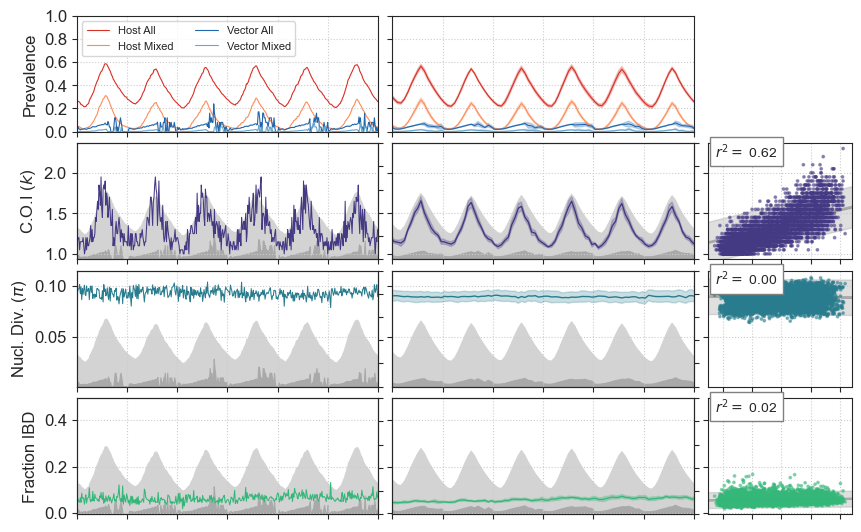

In [19]:
# Plot
fig = plt.figure(figsize=(10, n_metrics*2.2))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
gs = gridspec.GridSpec(n_metrics + 1, 5)


# Plot prevalence
ax0 = plt.subplot(gs[0, :2])
ax1 = plt.subplot(gs[0, 2:4], sharey=ax0)
ax2 = plt.subplot(gs[0, 4], sharey=ax1)

# Raw
prevalence_trajectory_plot(ot, epoch_df, ax0,
                           col_dt=prevalence_col_dt,
                           norm_t0=("Wet2009", "t0"),
                           #indicate_epochs=[("Wet20%02d" % y, "t0") for y in np.arange(9, 15)],
                           indicate_equilibriums=None,
                           time_limits=time_limits,
                           years_per_major_tick=1)
ax0.set_ylabel("Prevalence", fontsize=12)
ax0.legend(loc="upper left", ncol=2, fontsize=8)
ax0.grid(which='major', axis='both', linestyle='dotted')

# Averaged
prevalence_trajectory_average_plot(ots_mu, ots_se, epoch_df, ax1,
                                   col_dt=prevalence_col_dt,
                                   norm_t0=("Wet2009", "t0"),
                                   #indicate_epochs=[("Wet20%02d" % y, "t0") for y in np.arange(9, 15)],
                                   indicate_equilibriums=None,
                                   time_limits=time_limits,
                                   years_per_major_tick=1)
ax1.grid(which='major', axis='both', linestyle='dotted')

p = plt.setp(ax1.get_yticklabels(), visible=False)
p = plt.setp(ax2.get_yticklabels(), visible=False)

ax0.set_xticklabels("")
ax1.set_xticklabels("")
ax2.set_xticklabels("")
ax2.axis("off")


# Plot genetics
for j, metric in enumerate(metrics):
    ax0 = plt.subplot(gs[j + 1, :2])
    ax1 = plt.subplot(gs[j + 1, 2:4], sharey=ax0)
    ax2 = plt.subplot(gs[j + 1, 4], sharey=ax1)

    # Raw
    genetic_trajectory_plot(metric, ot, epoch_df,
                            tight_metric_col_dt[metric], ax0,
                            norm_t0=("Wet2009", "t0"),
                            #indicate_epochs=[("Wet20%02d" % y, "t0") for y in np.arange(9, 15)],
                            time_limits=time_limits,
                            years_per_major_tick=1)
    ax0.set_ylabel(genetic_names[metric], fontsize=12)
    ax0.grid(which='major', axis='both', linestyle='dotted')
    
    
    # Averaged
    genetic_trajectory_average_plot(metric, ots_mu, ots_se, epoch_df,
                                    tight_metric_col_dt[metric], ax1,
                                    norm_t0=("Wet2009", "t0"),
                                    #indicate_epochs=[("Wet20%02d" % y, "t0") for y in np.arange(9, 15)],
                                    time_limits=time_limits,
                                    years_per_major_tick=1)
    ax1.grid(which='major', axis='both', linestyle='dotted')
    
    
    # Scatterplot
    regress_scatterplot(metric, "HX", ot_all.query("@time_limits[0] <= t0 <= @time_limits[1]"),
                        color=tight_metric_col_dt[metric],  s=3.0, alpha=0.5,                   
                        ax=ax2)
    
    ax2.set_xticks(np.arange(0.2, 0.7, 0.1))
    ax2.grid(which='major', axis='both', linestyle='dotted')
    p = plt.setp(ax1.get_yticklabels(), visible=False)
    p = plt.setp(ax2.get_yticklabels(), visible=False)
    
    if metric != "avg_l_ibd":
        ax0.set_xticklabels("")
        ax1.set_xticklabels("")
        ax2.set_xticklabels("")
    else:
        ax0.set_xlabel("Time [years]", fontsize=12)
        ax1.set_xlabel("Time [years]", fontsize=12)
        
            
if savefig:
    fig.savefig(os.path.join(output_dir, "sec4_main-prevalence.png"), bbox_inches="tight", pad_inches=0.5)
    fig.savefig(os.path.join(output_dir, "sec4_main-prevalence.pdf"), bbox_inches="tight", pad_inches=0.5)